# SixTrackLib

### ... and GPU simulations of particle beams in synchrotrons

<br /><br />

##### a notebook talk by Adrian Oeftiger (GSI) and Martin Schwinzerl (CERN, Uni Graz)

AMD and GSI meeting on 2 November 2020. See also [rendered talk on github $\nearrow$](https://aoeftiger.github.io/AMD-GSI-SixTrackLib-11-2020/) besides [source in github repo $\nearrow$](https://github.com/aoeftiger/AMD-GSI-SixTrackLib-11-2020/).

<br />
<center>
    <small>(hit space to go to the next slide)</small>
</center>

# ... the origins ...

Legacy simulation code [`SixTrack` $\nearrow$](http://sixtrack.web.cern.ch/SixTrack/):

* used in volunteered computing network BOINC: 
[40TFLOPS, >170'000 registered users $\nearrow$](https://lhcathome.cern.ch/lhcathome/server_status.php)
* 72'000 lines of `Fortran77/90` code
* **identical** numerical results across OS and hardware platforms
* re-implemented from scratch as C-templated code `SixTrackLib`
* adding GPU support via `openCL` (and `CUDA`)

$\implies$ aim for both 1) distributed BOINC computing and 2) HPC on GPU clusters

<div style="margin: auto; width: 60%;">
    <img src="images/boinc.png" alt="BOINC logo" style="width: 30%; float:left; margin-top: 25px;" />
    <img src="images/lhcathome.png" alt="LHC@home logo" style="width: 40%; float:left; margin-left: 10%;" />
</div>

# ... the applications of `SixTrackLib` ...

## GSI: SIS100 Magnet Field Errors

* SIS100 heavy-ion synchrotron under construction at GSI
* new magnets (dipoles, quadrupoles) built, measurements of field quality

$\implies$ `SixTrackLib` helps to evaluate impact of field errors on beam dynamics (long-term beam storage for 160'000 revolutions): 

$\implies$ now 2 mins instead of 16 h / simulation

<div style="width:80%; margin: auto;">
    <img src="images/SIS100-allerrors.png" alt="SIS100 full errors" style="width: 40%; float:left; margin-top: 0;" />
    <img src="images/SIS100-diperrors.png" alt="SIS100 dipole errors" style="width: 40%; float:left; margin-left:10%; margin-top: 0;" />
</div>

# ... the modelled physics ...

# Beam Model

3D particle motion $\leadsto$ 6 phase space coordinates:
$$\mathbb{X}=(\underbrace{x, x'\vphantom{y'}}_{horizontal}, \underbrace{y, y'}_{vertical}, \underbrace{z, \delta\vphantom{y'}}_{longitudinal})$$

A beam $=$ state of $N$ macro-particles $=$ $6N$ values of phase space coordinates

<center>
    <img src="images/bunch.png" alt="particle bunch sketch" style="width:30%;" />
</center>

# Accelerator Model

Symplectic non-linear 6D tracking through elements along accelerator ring:

<p style="width: 80%; margin: 25px auto;">
    <img src='images/sis100.jpg' alt='SIS100 layout' style='width: 30%; float: left; margin-top: 0;' />
    <img src="images/transverse-model_empty.png" alt="sketch of one-turn map for ring" style="width:30%; float: left; margin-left: 5%; margin-top: 0;" />
    <img src="images/tracking.png" alt="tracking sketch" style="width:30%; float: left; margin-left: 5%; margin-top: 0;" />
</p>

# ... the numerics ...

## Simulations Requirements:


* **accurate**: long-term evolution $\leadsto$ double precision
* **fast**: heavy number crunching $\leadsto$ high-performance computing (HPC)<br />(in particular GPU parallelisation)
* **flexible**: iterative development of accelerator models with frequent updates $\leadsto$ python (API)

## Pseudo Code

```python
for n in range(nturns):
    for el_type, el_params in elements:
        for p in particles: // parallel!
            p = track[el_type](el_params, p)
```

$\implies$ **embarrassingly parallel** simulations: particles treated separately

$\leadsto$ current implementation: single kernel with case-switch in `openCL`

| What                   || Typical numbers                                     |
| :--------------------- || ---------------------------------------------------:|
| simulation length      || $\mathcal{O}(10^4)$ to $\mathcal{O}(10^7)$ `nturns` |
| accelerator `elements` || $\mathcal{O}(10^3)$ to $\mathcal{O}(10^5)$          |
| element types ($10$ to $20$) || $20$ to $\mathcal{O}(10^5)$ arithmetic operations |
| element parameters     || $1$ to $50$ `el_params`                             |
| macro-`particles`      || $\mathcal{O}(10^4)$ to $\mathcal{O}(10^6)$          |

<!-- 
* simulation length: $\mathcal{O}(10^4)$ to $\mathcal{O}(10^7)$ `nturns`
* accelerator `elements` ($1$ to $50$ `el_params`): $\mathcal{O}(10^3)$ to $\mathcal{O}(10^5)$
* macro-`particles`: $\mathcal{O}(10^4)$ to $\mathcal{O}(10^6)$
* element `el_type`s ($10$ to $20$): $20$ to $\mathcal{O}(10^5)$ arithmetic operations
-->
<!--* particle-to-particle interaction: binning, FFT, convolution, particle-in-cell, Poisson solvers-->

# ... what we are working on! ...

## Current Benchmarks

<div style="width:100%; margin: auto; ">
    <img src="images/stl_full.png" alt="SIS100 full errors" style="width: 45%; float:left; margin-top: 30px; margin-bottom: 30px;" />
    <img src="images/stl_optimised.png" alt="SIS100 dipole errors" style="width: 45%; float:left; margin-left:10%; margin-top: 30px; margin-bottom: 30px;" />
</div>

| AMD Radeon Instinct MI50 | AMD Radeon VII | NVIDIA RTX 2080 | NVIDIA V100 | CPU: AMD EPYC 7551 |
| ------------- | ---------- | --------------- | ----------- | ------------- |
| 6.7 TFLOPS | 3.5 TFLOPS | 0.44 TFLOPS | 7 TFLOPS | 0.65 TFLOPS |

## LHC Benchmark

<img src="images/perf.png" alt="LHC lattice benchmarking" style="width: 80%; margin: auto;" />

## Hardware aim for SixTrackLib 

* AMD Radeon Instinct cards in GSI HPC cluster
* lots of LHC@home users with AMD gaming GPUs

## Issues to collaborate on with AMD

1. detailed **profiling** on AMD GPU hardware
2. **register spilling** throttles throughput: parallelisation approach to be optimised?

## For topic 1: Profiling

Various setups:

| Environment | Card | Driver |
| :---------- | :--: | -----: |
| GSI cluster | Radeon Instinct MI50 | ROCM |
| GSI workstation | Radeon VII | amdgpu-pro |
| CERN workstation | Radeon VII | ROCM |

$\implies$ can provide a typical simulation setup to profile / benchmark

## For topic 2: Optimisation

$\implies$ Martin Schwinzerl implemented simple demo of SixTrackLib to play with:

[https://github.com/martinschwinzerl/demotrack](https://github.com/martinschwinzerl/demotrack)

* self-contained library in `openCL` (interfaced to `python` via `pyopencl`)
* particles, beam elements, track kernel
* light-weight elements (`Drift`, `Multipole`, `Cavity`) and suspected register spilling element (`SpaceChargeCoasting` using `cerrf`)

# Looking very forward to collaborate with you!

# Thank you for your attention

<div style="height:100px;">&nbsp;</div>

# // Appendix: SixTrackLib Example //

In [1]:
import numpy as np
import sixtracklib

import time

In [2]:
elements = sixtracklib.Elements.fromfile('sis100.bin')

nturns = 128
elements.BeamMonitor(num_stores=nturns);

In [3]:
npart = 50 * 1024
particles = sixtracklib.Particles.from_ref(npart, p0c=1e9)

In [4]:
particles.x += np.linspace(0, 1e-3, npart)
particles.y += -np.linspace(0, 1e-3, npart)

The trackjob will define the simulation kernel for us:

In [5]:
job = sixtracklib.TrackJob(elements, particles, device="opencl:2.0")

In [6]:
!clinfo -l

Platform #0: Portable Computing Language
 `-- Device #0: pthread-AMD Ryzen Threadripper 1950X 16-Core Processor
Platform #1: NVIDIA CUDA
 `-- Device #0: GeForce RTX 2080 Ti
Platform #2: AMD Accelerated Parallel Processing
 `-- Device #0: gfx906


## Let's track

In [7]:
t0 = time.time()

job.track_until(nturns)
job.collect()

dt = time.time() - t0
print (dt) #20.15 sec without BeamMonitor

20.447933435440063


# Evaluation:

In [8]:
rec_x = job.output.particles[0].x
rec_y = job.output.particles[0].y

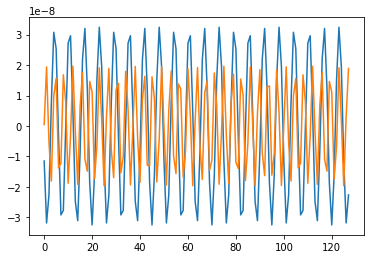

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(rec_x[1::npart])
plt.plot(rec_y[1::npart])